In [ ]:
! pip install -q equinox optax

In [ ]:
import jax.numpy as jnp
import numpy as np

from jax import config, random, vmap, jit, grad
from jax.lax import dot_general, scan
from jax.scipy.optimize import minimize
config.update("jax_enable_x64", True)

import optax
from functools import partial
import itertools
import sympy as sp
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import spsolve
from scipy.special import roots_legendre

import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

In the supervised setting, the essence of the approach is to

1. Generate a dataset
2. Train neural network in the standard regression setting
3. Compute certificates for the network predictions
4. Train the second network in the regression setting

Since training is quite standard, here we show

1. code that produces a dataset
2. code that computes certificates, upper bounds, etc.
3. implementation of a single neural network used in the preprint

The entirety of the code, training loops, etc will be released in later stages.

# Dataset generation and computation of certificates

In [ ]:
@jit
def d1(a, h):
    '''
    find derivative of a 1D functions given on uniform grid x

    a.shape = (N_features, N_x)
    h = grid spacing
    '''
    d_a = (jnp.roll(a, -1, axis=1) - jnp.roll(a, 1, axis=1)) / (2*h)
    d_a = d_a.at[:, 0].set((-3*a[:, 0]/2 + 2*a[:, 1] - a[:, 2]/2)/h) # 1/2	−2	3/2
    d_a = d_a.at[:, -1].set((a[:, -3]/2 - 2*a[:, -2] + 3*a[:, -1]/2)/h) # 1/2	−2	3/2
    return d_a

@partial(jit, static_argnums=(2,))
def d_fd(a, h, axis):
    '''
    find first derivative of nD function given on uniform grid

    a.shape = (N_features, N_x, N_y, N_z, ...) - input array for taking derivative
    h = grid spacing
    axis = dimension to take a derivative, 1 corresponds to dx, 2 orresponds to dy, ...
    '''
    d_a = d1(jnp.moveaxis(a, axis, 1), h)
    return jnp.moveaxis(d_a, axis, 1)

def energy_norm_a(u, a, x):
    # computes ||u||_a^2 with b = 0
    h = x[1] - x[0]
    a11, a12, a22 = a
    du_dx = d_fd(u, h, 1)[0]
    du_dy = d_fd(u, h, 2)[0]
    r = jnp.trapz(jnp.trapz(a11*du_dx**2 + 2*a12*du_dx*du_dy + a22*du_dy**2, x), x)
    return r

def energy_norm_b(u, b, x):
    # computes ||bu||_2^2
    r = jnp.trapz(jnp.trapz(b**2*u[0]**2, x), x)
    return r

def energy_norm(u, a, b, x):
    return energy_norm_a(u, a, x) + energy_norm_b(u, b, x)

def energy_norm_indicator(u, a, b, x):
    h = x[1] - x[0]
    a11, a12, a22 = a
    du_dx = d_fd(u, h, 1)[0]
    du_dy = d_fd(u, h, 2)[0]
    return a11*du_dx**2 + 2*a12*du_dx*du_dy + a22*du_dy**2 + b**2*u[0]**2

def compute_flux(u, a, x):
    # computes a\nabla u
    h = x[1] - x[0]
    a11, a12, a22 = a
    du_dx = d_fd(u, h, 1)[0]
    du_dy = d_fd(u, h, 2)[0]
    return jnp.stack([a11*du_dx + a12*du_dy, a12*du_dx + a22*du_dy], 0)

def inv_a_norm(u, a, x):
    # computes ||u||_{a^{-1}}^2
    h = x[1] - x[0]
    a11, a12, a22 = a
    d = a11*a22 - a12**2
    b11, b12, b22 = a22 / d, -a12 / d, a22 / d
    r = jnp.trapz(jnp.trapz(b11*u[0]**2 + 2*b12*u[0]*u[1] + b22*u[1]**2, x), x)
    return r

def inv_a_norm_indicator(u, a, x):
    h = x[1] - x[0]
    a11, a12, a22 = a
    d = a11*a22 - a12**2
    b11, b12, b22 = a22 / d, -a12 / d, a22 / d
    return b11*u[0]**2 + 2*b12*u[0]*u[1] + b22*u[1]**2

def min_eigenvalue(a):
    # computes \inf_x\min\lambda(a)
    a11, a12, a22 = a
    m = (a11 + a22)/2
    d = a11*a22 - a12**2
    lambda_min = m - jnp.sqrt(m**2 - d)
    return jnp.min(lambda_min)

def compute_C(a):
    # upper bound for C in 2D
    l_min = min_eigenvalue(a)
    return 1/(2*jnp.pi*jnp.sqrt(l_min))

def upper_bound(params, v, a, b, f, C, x):
    # complete upper bound for energy norm
    h = x[1] - x[0]
    y, beta = params
    a_v = compute_flux(v, a, x)
    R = f - b**2 * v[0] + d_fd(y[:1], h, 1)[0] + d_fd(y[1:], h, 2)[0]
    norm_a_ = inv_a_norm(a_v - y, a, x)*(1 + beta)/beta
    return jnp.trapz(jnp.trapz(R**2*C**2*(1+beta)/(C**2*(1+beta)*b**2 + 1), x), x) + norm_a_

def upper_bound_indicator(params, v, a, b, f, C, x):
    h = x[1] - x[0]
    y, beta = params
    a_v = compute_flux(v, a, x)
    R = f - b**2 * v[0] + d_fd(y[:1], h, 1)[0] + d_fd(y[1:], h, 2)[0]
    norm_a_ = inv_a_norm_indicator(a_v - y, a, x)*(1 + beta)/beta
    return norm_a_ + R**2*C**2*(1+beta)/(C**2*(1+beta)*b**2 + 1)

def compute_J(u, a, b, f, x):
    return energy_norm_a(u, a, x)/2 + energy_norm_b(u, b, x)/2 - jnp.trapz(jnp.trapz(f*u[0], x), x)

def compute_lower_bound(params, u, a, b, f, x):
    v, = params
    return 2*(compute_J(u, a, b, f, x) - compute_J(u+v, a, b, f, x))

def even_cubic(v):
    v_ = jnp.hstack([(5*v[0] + 15*v[1] - 5*v[2] + v[3])/16, (-v[:-3] + 9*jnp.roll(v, -1)[:-3] + 9*jnp.roll(v, -2)[:-3] - jnp.roll(v, -3)[:-3])/16, (v[-4] - 5*v[-3] + 15*v[-2] + 5*v[-1])/16])
    interpolated_coarse = jnp.zeros((v_.shape[0]+v.shape[0], ))
    interpolated_coarse = interpolated_coarse.at[::2].set(v)
    interpolated_coarse = interpolated_coarse.at[1::2].set(v_)
    return interpolated_coarse

def compute_residual(u, a, b, f, x):
    a11, a12, a22 = a
    h = x[1] - x[0]
    ux = d_fd(u, h, 1)
    uy = d_fd(u, h, 2)
    res = f - (-d_fd(ux*jnp.expand_dims(a11, 0), h, 1)[0] - d_fd(uy*jnp.expand_dims(a22, 0), h, 2)[0] - d_fd(ux*jnp.expand_dims(a12, 0), h, 2)[0] - d_fd(uy*jnp.expand_dims(a12, 0), h, 1)[0] + b**2 * u[0])
    return res

def compute_loss(params, problem_data):
    solution_coarse, a_coarse, b_coarse, f_coarse, C, x_coarse = problem_data
    return upper_bound([params[0], params[1]**2], solution_coarse, a_coarse, b_coarse, f_coarse, C, x_coarse)[0]

@partial(jit, static_argnums=(2,))
def make_step(params, problem_data, optim, opt_state):
    grads = grad(compute_loss)(params, problem_data)
    updates, opt_state = optim.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state

def compute_certificate(problem_data, optim, N_epoch=1000):
    flux = compute_flux(problem_data[0], problem_data[1], problem_data[-1])
    params = [flux, jnp.array([1.0,])]
    opt_state = optim.init(params)

    def opt_step(carry, ind):
        params, opt_state, problem_data = carry
        params, opt_state = make_step(params, problem_data, optim, opt_state)
        r = compute_loss(params, problem_data)
        carry = params, opt_state, problem_data
        return carry, r

    carry = params, opt_state, problem_data
    t_ = jnp.arange(N_epoch)
    res, errors = scan(opt_step, carry, t_)
    return [res[0][0], res[0][1]**2]

def compute_smoothed_loss(params, model, problem_data):
    solution_coarse, a_coarse, b_coarse, f_coarse, C, x_coarse = problem_data
    return upper_bound([model(params[0]), params[1]**2], solution_coarse, a_coarse, b_coarse, f_coarse, C, x_coarse)[0]

@partial(jit, static_argnums=(1, 3,))
def make_smoothed_step(params, model, problem_data, optim, opt_state):
    grads = grad(compute_smoothed_loss)(params, model, problem_data)
    updates, opt_state = optim.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    return params, opt_state

def compute_smoothed_certificate(problem_data, optim, N_epoch=1000, N=7):
    flux = compute_flux(problem_data[0], problem_data[1], problem_data[-1])
    K = problem_data[0].shape[-1]
    x = jnp.linspace(0, 1, K)
    x, y = jnp.meshgrid(x, x)
    M = jnp.stack([(x**i*y**j).reshape(-1,) for i, j in itertools.product(range(N), repeat=2)], 0)
    model = lambda params: (params @ M).reshape(-1, K, K)
    Q, R = jnp.linalg.qr(M.T)
    p = flux.reshape(2, -1) @ Q
    params = [jnp.linalg.solve(R, p.T).T, jnp.array([1.0,])]
    opt_state = optim.init(params)

    def opt_step(carry, ind):
        params, opt_state, problem_data = carry
        params, opt_state = make_smoothed_step(params, model, problem_data, optim, opt_state)
        r = compute_smoothed_loss(params, model, problem_data)
        carry = params, opt_state, problem_data
        return carry, r

    carry = params, opt_state, problem_data
    t_ = jnp.arange(N_epoch)
    res, errors = scan(opt_step, carry, t_)
    return [model(res[0][0]), res[0][1]**2]

def tent(x, center, h):
    left_mask = (x <= center) & (x >= (center - h))
    right_mask = (x > center) & (x <= (center + h))
    y = (x - center)/h
    return (1. - y) * right_mask + (1. + y) * left_mask

def d_tent(x, center, h):
    left_mask = (x < center) & (x >= (center - h))
    right_mask = (x > center) & (x <= (center + h))
    return (-1. * right_mask + left_mask) / h

def FEM_2D(N_points, F, M_int=8, backend="jax"):
    # dx (a1 dx) + dy (a2 dy) + dx (a12 dy) + dy (a21 dx) + dx b1 + dy b2 + c
    a1, a2, a12, a21, b1, b2, c, f = F
    coords, w = roots_legendre(M_int)
    w = jnp.array(w)
    w_ = jnp.hstack([w, w])
    ind = []
    values = []
    rhs = []
    h = 1/(N_points+1)
    lex = lambda i, j: i + N_points*j

    def discretization(carry, ind):
        w_, coords, h  = carry
        j, i = ind[0], ind[1]
        x, y = (i+1)*h, (j+1)*h
        x_ = jnp.hstack([x - h/2 + coords*h/2, x + h/2 + coords*h/2])
        y_ = jnp.hstack([y - h/2 + coords*h/2, y + h/2 + coords*h/2])
        X_, Y_ = jnp.meshgrid(x_, y_, indexing="ij")
        a_1 = - a1(X_, Y_) * d_tent(x_, x, h).reshape(-1, 1) * tent(y_, y, h).reshape(1, -1)
        a_12 = - a12(X_, Y_) * d_tent(x_, x, h).reshape(-1, 1) * tent(y_, y, h).reshape(1, -1)
        a_2 = - a2(X_, Y_) * d_tent(y_, y, h).reshape(1, -1) * tent(x_, x, h).reshape(-1, 1)
        a_21 = - a21(X_, Y_) * d_tent(y_, y, h).reshape(1, -1) * tent(x_, x, h).reshape(-1, 1)
        b_1 = - b1(X_, Y_) * d_tent(x_, x, h).reshape(-1, 1) * tent(y_, y, h).reshape(1, -1)
        b_2 = - b2(X_, Y_) * d_tent(y_, y, h).reshape(1, -1) * tent(x_, x, h).reshape(-1, 1)
        c_ = c(X_, Y_) * tent(x_, x, h).reshape(-1, 1) * tent(y_, y, h).reshape(1, -1)
        res = [] # row, col, value, i, j
        for p1, p2 in itertools.product([-1, 0, +1], repeat=2):
            v = a_1 * d_tent(x_, x + p1*h, h).reshape(-1, 1) * tent(y_, y + p2*h, h).reshape(1, -1)
            v += a_12 * d_tent(y_, y + p2*h, h).reshape(1, -1) * tent(x_, x + p1*h, h).reshape(-1, 1)
            v += a_2 * d_tent(y_, y + p2*h, h).reshape(1, -1) * tent(x_, x + p1*h, h).reshape(-1, 1)
            v += a_21 * d_tent(x_, x + p1*h, h).reshape(-1, 1) * tent(y_, y + p2*h, h).reshape(1, -1)
            v += (b_1 + b_2 + c_) * tent(y_, y + p2*h, h).reshape(1, -1) * tent(x_, x + p1*h, h).reshape(-1, 1)
            res += [[lex(i, j), lex(i+p1, j+p2), w_ @ v @ w_, i + p1, j + p2]]
        return carry, jnp.array(res)

    def rhs_discretization(carry, ind):
        w_, coords, h  = carry
        j, i = ind[0], ind[1]
        x, y = (i+1)*h, (j+1)*h
        x_ = jnp.hstack([x - h/2 + coords*h/2, x + h/2 + coords*h/2])
        y_ = jnp.hstack([y - h/2 + coords*h/2, y + h/2 + coords*h/2])
        X_, Y_ = jnp.meshgrid(x_, y_, indexing="ij")
        res = w_ @ (f(X_, Y_) * tent(x_, x, h).reshape(-1, 1) * tent(y_, y, h).reshape(1, -1)) @ w_
        return carry, res

    xs = jnp.array([*itertools.product(range(N_points), repeat=2)])
    carry = [w_, coords, h]
    carry, res = scan(discretization, carry, xs)
    carry, rhs = scan(rhs_discretization, carry, xs)

    for_mask = jnp.array(res[:, :, 3:], dtype=int)
    mask = ((for_mask[:, :, 0] < N_points) & (0 <= for_mask[:, :, 0]) & (for_mask[:, :, 1] < N_points) & (0 <= for_mask[:, :, 1])).reshape(-1, )
    res = res[:, :, :3].reshape(-1, 3)[mask]
    ind = jnp.array(res[:, :2], dtype=int)
    values = res[:, 2]
    return np.array(rhs), coo_matrix((np.array(values), (np.array(ind[:, 0]), np.array(ind[:, 1]))), shape=(N_points**2, N_points**2)).tocsr()

def solve_BVP_2D_scipy(N_points, F):
    rhs, A = FEM_2D(N_points-2, F, M_int=8, backend="scipy")
    sol_ = spsolve(A, rhs)
    sol = np.zeros((N_points, N_points))
    sol[1:-1, 1:-1] = sol_.reshape((N_points-2, N_points-2))
    return jnp.array(sol.reshape(-1,))

def random_polynomial_2D(x, y, coeff):
    res = 0
    for i, j in itertools.product(range(coeff.shape[0]), repeat=2):
        res += coeff[i, j]*jnp.exp(2*jnp.pi*x*i*1j)*jnp.exp(2*jnp.pi*y*j*1j)/(1+i+j)**2
    res = jnp.real(res)
    return res

def get_functions_1(key):
    c_ = random.normal(key, (5, 5, 5), dtype=jnp.complex128)
    alpha = lambda x, y, c=c_[0]: random_polynomial_2D(x, y, c)*0.1 + 1
    beta = lambda x, y, c=c_[1]: random_polynomial_2D(x, y, c)*0.1 + 1
    gamma = lambda x, y, c=c_[2]: random_polynomial_2D(x, y, c)
    c = lambda x, y, c=c_[3]: random_polynomial_2D(x, y, c)
    rhs = lambda x, y, c=c_[4]: random_polynomial_2D(x, y, c)
    a11 = lambda x, y: alpha(x, y)**2
    a12 = lambda x, y: alpha(x, y)*gamma(x, y)
    a22 = lambda x, y: beta(x, y)**2 + gamma(x, y)**2
    return a11, a22, a12, c, rhs

def get_F(a11, a22, a12, c, rhs):
    return [a11, a22, a12, a12, lambda x, y: jnp.zeros_like(x), lambda x, y: jnp.zeros_like(x), lambda x, y: -c(x, y)**2, lambda x, y: -rhs(x, y)]

def get_data(J, F):
    N_points = 2**J + 1
    x = jnp.linspace(0, 1, N_points)
    X, Y = jnp.meshgrid(x, x, indexing="ij")
    solution = solve_BVP_2D_scipy(N_points, F).reshape(1, N_points, N_points, order="F")

    a = [F[0](X, Y), F[2](X, Y), F[1](X, Y)]
    b = jnp.sqrt(-F[6](X, Y))
    f = -F[-1](X, Y)

    return solution, a, b, f, x

def get_functional_error_dataset(key, J_coarse, J_fine, N_samples, get_functions):
    keys = random.split(key, N_samples)
    sol = []
    features = []
    exact_sol = []
    errors = []
    C = []
    for key in keys:
        a11, a22, a12, c, rhs = get_functions(key)
        F = get_F(a11, a22, a12, c, rhs)
        solution, a, b, f, x = get_data(J_coarse, F)
        exact_solution, a_, b_, f_, x_ = get_data(J_fine, F)
        features.append(jnp.stack(a + [b, f], 0))
        sol.append(solution)
        exact_sol.append(exact_solution[:, ::4, ::4])
        e = jnp.sqrt(energy_norm(solution - exact_solution[:, ::4, ::4], a, b, x))
        errors.append(e)
        C.append(compute_C(a))

    dataset = {
        "solution": jnp.stack(sol, 0),
        "exact_sol": jnp.stack(exact_sol, 0),
        "features": jnp.stack(features, 0),
        "errors": jnp.stack(errors, 0),
        "C": jnp.stack(C, 0)
    }
    return dataset

def get_functional_error_dataset_1(key, N_samples):
    return get_functional_error_dataset(key, 5, 7, N_samples, get_functions_1)

## Dataset generation

In [ ]:
key = random.PRNGKey(11)
N_samples = 3
data = get_functional_error_dataset_1(key, N_samples)

In [ ]:
data["solution"].shape, data["features"].shape, data["errors"].shape, data["exact_sol"].shape, data["C"].shape

((3, 1, 33, 33), (3, 5, 33, 33), (3,), (3, 1, 33, 33), (3,))

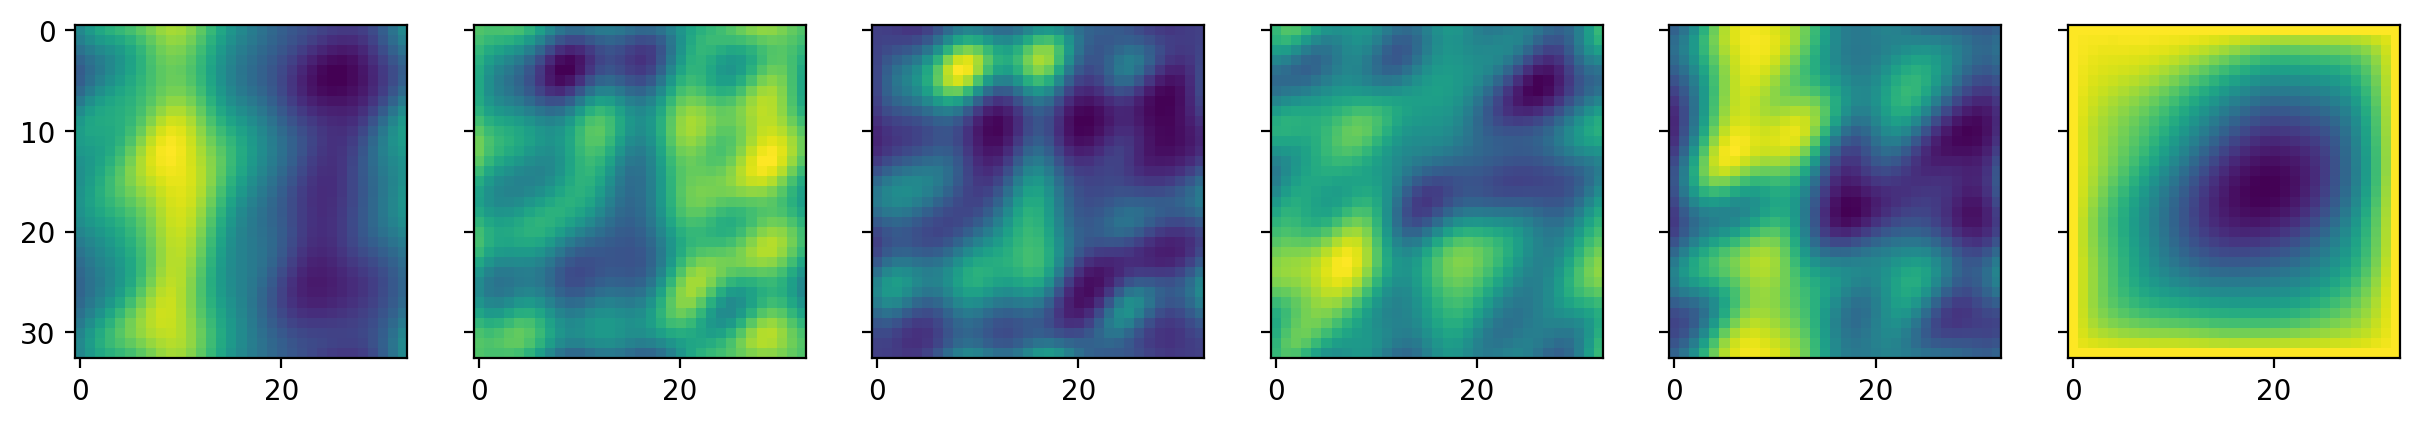

In [ ]:
fig, ax = plt.subplots(1, 6, figsize=(15, 3), sharex=True, sharey=True)

sample = 2
for i in range(5):
  ax[i].imshow(data["features"][sample, i])

ax[-1].imshow(data["solution"][sample, 0]);

## Computation of upper bound

Error are already estimated in the dataset generation process.

Below we find certificates by optimization.

In [ ]:
x = jnp.linspace(0, 1, data["solution"].shape[-1])

learning_rate = 1e-4
sc = optax.exponential_decay(learning_rate, 5000, 0.9)
weight_decay = 1e-10
optim = optax.adamw(learning_rate, weight_decay=weight_decay)

problem_data = [data["solution"][sample], data["features"][sample][:3], data["features"][sample][3:4], data["features"][sample][4:], data["C"][sample], x]

v, beta = compute_certificate(problem_data, optim)

And find upper bound using these certificates.

In [ ]:
ub = upper_bound([v, beta], data["solution"][sample], data["features"][sample][:3], data["features"][sample][3:4], data["features"][sample][4:], data["C"][sample], x)

In [ ]:
print(f"Error {data['errors'][sample].item()}, upper bound {jnp.sqrt(ub)[0].item()}")

Error 0.00026184704606843656, upper bound 0.0030933280233688917


# Neural network reference implementation

As an example, we provide DilResNet used in our experiments.

In [ ]:
import jax.numpy as jnp
import equinox as eqx

from typing import Callable
from jax import config, random, vmap
from jax.nn import relu
config.update("jax_enable_x64", True)

class DilatedConvBlock(eqx.Module):
    convolutions: list
    activation: Callable

    def __init__(self, channels, dilations_D, kernel_sizes_D, key, activation=relu):
        # 1D example: channels = [3, 40, 40, 1], dilations_D = [[1,], [1,], [1]], kernel_sizes_D = [[3,], [3,], [3,]]
        # 2D example: channels = [3, 40, 40, 1], dilations_D = [[4, 4], [3, 3], [2, 1]], kernel_sizes_D = [[3, 4], [3, 4], [4, 5]]
        kernel_sizes_D = [[k if k%2 == 1 else k+1 for k in kernel_sizes] for kernel_sizes in kernel_sizes_D]
        paddings_D = [[d*(k//2) for d, k in zip(dilations, kernel_sizes)] for dilations, kernel_sizes in zip(dilations_D, kernel_sizes_D)]
        keys = random.split(key, len(channels))
        D = len(kernel_sizes_D[0])
        self.convolutions = [eqx.nn.Conv(num_spatial_dims=D, in_channels=f_i, out_channels=f_o, dilation=d, kernel_size=k, padding=p, key=key) for f_i, f_o, d, k, p, key in zip(channels[:-1], channels[1:], dilations_D, kernel_sizes_D, paddings_D, keys)]
        self.activation = activation

    def __call__(self, x):
        for conv in self.convolutions[:-1]:
            x = self.activation(conv(x))
        x = self.convolutions[-1](x)
        return x

    def linear_call(self, x):
        for conv in self.convolutions:
            x = conv(x)
        return x

class DilatedResNet(eqx.Module):
    encoder: eqx.Module
    decoder: eqx.Module
    processor: list
    activation: Callable

    def __init__(self, key, channels, n_cells, activation=relu, kernel_size=3, D=1):
        in_channels, processor_channels, out_channels = channels
        keys = random.split(key, 3)
        self.encoder = DilatedConvBlock([in_channels, processor_channels], [[1,]*D,], [[kernel_size,]*D,], keys[0])
        self.decoder = DilatedConvBlock([processor_channels, out_channels], [[1,]*D,], [[kernel_size,]*D,], keys[1])
        keys = random.split(keys[2], n_cells)
        channels_ = [processor_channels,]*8
        dilations = [[1,]*D, [2,]*D, [4,]*D, [8,]*D, [4,]*D, [2,]*D, [1,]*D]
        kernel_sizes = [[kernel_size,]*D,]*7
        self.processor = [DilatedConvBlock(channels_, dilations, kernel_sizes, key, activation=activation) for key in keys]
        self.activation = activation

    def __call__(self, x):
        x = self.encoder(x)
        for pr in self.processor[:-1]:
            x = self.activation(pr(x)) + x
        x = self.processor[-1](x) + x
        x = self.decoder(x)
        return x

    def linear_call(self, x):
        x = self.encoder(x)
        for pr in self.processor:
            x = pr(x) + x
        x = self.decoder(x)
        return x

def compute_loss(model, input, target):
    output = vmap(lambda z: model(z), in_axes=(0,))(input)
    l = jnp.mean(jnp.linalg.norm((output - target).reshape(input.shape[0], -1), axis=1)**2)
    return l

compute_loss_and_grads = eqx.filter_value_and_grad(compute_loss)

@eqx.filter_jit
def make_step(model, input, target, optim, opt_state):
    loss, grads = compute_loss_and_grads(model, input, target)
    updates, opt_state = optim.update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

@eqx.filter_jit
def make_step_m(model, input, target, optim, opt_state):
    # for optimizers that require model for update, e.g. adamw
    loss, grads = compute_loss_and_grads(model, input, target)
    updates, opt_state = optim.update(grads, opt_state, eqx.filter(model, eqx.is_array))
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

In [ ]:
key = random.PRNGKey(11)
channels = [1, 32, 1]
n_cells = 4
D = 2
model = DilatedResNet(key, channels, n_cells, D=2)
print(model)

DilatedResNet(
  encoder=DilatedConvBlock(
    convolutions=[
      Conv(
        num_spatial_dims=2,
        weight=f64[32,1,3,3],
        bias=f64[32,1,1],
        in_channels=1,
        out_channels=32,
        kernel_size=(3, 3),
        stride=(1, 1),
        padding=((1, 1), (1, 1)),
        dilation=(1, 1),
        groups=1,
        use_bias=True
      )
    ],
    activation=<wrapped function relu>
  ),
  decoder=DilatedConvBlock(
    convolutions=[
      Conv(
        num_spatial_dims=2,
        weight=f64[1,32,3,3],
        bias=f64[1,1,1],
        in_channels=32,
        out_channels=1,
        kernel_size=(3, 3),
        stride=(1, 1),
        padding=((1, 1), (1, 1)),
        dilation=(1, 1),
        groups=1,
        use_bias=True
      )
    ],
    activation=<wrapped function relu>
  ),
  processor=[
    DilatedConvBlock(
      convolutions=[
        Conv(
          num_spatial_dims=2,
          weight=f64[32,32,3,3],
          bias=f64[32,1,1],
          in_channels=32